# Extract the data from EVADEV

In [212]:
import re
from datetime import datetime

from ete3 import NCBITaxa
from ebi_eva_common_pyutils.metadata_utils import get_metadata_connection_handle
from ebi_eva_common_pyutils.pg_utils import get_all_results_for_query
from ebi_eva_common_pyutils.ncbi_utils import get_ncbi_assembly_dicts_from_term, get_ncbi_taxonomy_dicts_from_ids, \
    get_ncbi_taxonomy_dicts_from_term

assembly_to_species_cache = {}
taxonomy_to_species_cache = {}
api_key = '01a7cfd97228eee442256df079d3581cdd09'

ete_db = NCBITaxa()

def unique_on_keys(list_of_dict, keys):
    unique_values = {
        tuple((key, d.get(key)) for key in keys) for d in list_of_dict
    }
    return [dict(set_of_values) for set_of_values in unique_values]

def taxonomy_from_assembly(assembly):
    if assembly not in assembly_to_species_cache:
        assembly_info_list = get_ncbi_assembly_dicts_from_term(assembly, api_key=api_key)
        assembly_info_list = unique_on_keys(assembly_info_list, ['taxid'])
        if len(assembly_info_list) == 1:
            assembly_to_species_cache[assembly] = assembly_info_list[0]['taxid']
        else:
            print(f'No species found from assembly={assembly}')
            assembly_to_species_cache[assembly] = None
    return assembly_to_species_cache[assembly]

def species_detail_from_name_or_taxonomy(species_term=None, taxonomy_id=None):
    return_info = ['scientificname', 'taxid', 'commonname']
    if taxonomy_id and taxonomy_id not in taxonomy_to_species_cache:
        taxonomy_info_list = get_ncbi_taxonomy_dicts_from_ids([taxonomy_id], api_key=api_key)
        taxonomy_info_list = unique_on_keys(taxonomy_info_list, return_info)
        if len(taxonomy_info_list) == 1:
            taxonomy_to_species_cache[taxonomy_id] = taxonomy_info_list[0]
        else:
            print(f'No species information found from taxonomy_id={taxonomy_id}')
            taxonomy_to_species_cache[taxonomy_id] = None
    elif species_term and species_term not in taxonomy_to_species_cache:
        taxonomy_info_list = get_ncbi_taxonomy_dicts_from_term(species_term, api_key=api_key)
        taxonomy_info_list = unique_on_keys(taxonomy_info_list, return_info)
        if len(taxonomy_info_list) == 1:
            taxonomy_to_species_cache[species_term] = taxonomy_info_list[0]
        else:
            print(f'No species information found from species_term={species_term}')
            taxonomy_to_species_cache[species_term] = None
    if taxonomy_id:
        return  taxonomy_to_species_cache[taxonomy_id]
    elif species_term:
        return  taxonomy_to_species_cache[species_term]


def extract_information_from_release_filename(file_name):
    sp_file_name = file_name.split('/')
    release = sp_file_name[5]
    species_match = re.search('by_species/(.+?)/', file_name)
    accession_match = re.search('(GCA_\d{9}\.\d)', file_name)
    info_dict = None
    if species_match:
        species_match_group = species_match.group(1)
        info_dict = species_detail_from_name_or_taxonomy(species_term=species_match_group.replace('_', ' '))
        if not info_dict and species_match_group.split('_')[-1].isdigit():
            info_dict = species_detail_from_name_or_taxonomy(taxonomy_id=species_match_group.split('_')[-1])
    if not info_dict and accession_match:
        assembly_accession = accession_match.group(1)
        taxonomy_id = taxonomy_from_assembly(assembly_accession)
        info_dict = species_detail_from_name_or_taxonomy(taxonomy_id=taxonomy_id)
    if info_dict:
        # Get all the taxids of the ranks above in the taxonomy tree
        lineage = ete_db.get_lineage(int(info_dict['taxid']))
        # Get the rank of each taxonomy ids
        ranks = ete_db.get_rank(lineage)
        # Only use rank class
        required_rank = 'class'
        # Get the taxonomy of the class
        taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
        # Get the name of the class
        sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
        name_of_required_rank = ete_db.get_common_names(taxid_for_rank).get(taxid_for_rank[0]) or ete_db.get_taxid_translator(taxid_for_rank).get(taxid_for_rank[0]) or taxid_for_rank[0]
        info_dict[required_rank] = name_of_required_rank
        info_dict['release'] = release
        return info_dict
    else:
        return {'release': release}

In [213]:
# File containing password not committed to the repository
private_config_xml_file = 'maven_settings.xml'
query = '''select event_ts, uhost,  file_name, file_size
           from eva_web_srvc_stats.ftp_traffic
           where file_size>0 and domain_name != 'ebi.ac.uk' and file_name  like '%rs_releases%';'''
with get_metadata_connection_handle('development', private_config_xml_file) as db_conn:
        data = get_all_results_for_query(db_conn, query)
print(data[:10])

[(datetime.datetime(2021, 10, 5, 23, 17, 53, 223000), 'edda2e8e79cee2b44f60a6e17fbe0776832cfb7a80d2454c591bc85df5dc71f43410b6a3bf23df47ca690e5ed7cc77ac14c5e3c32aa370fc93630b1685729316', '/pub/databases/eva/rs_releases/release_2/by_assembly/GCA_000001635.6/GCA_000001635.6_current_ids.vcf.gz', 1107929260), (datetime.datetime(2021, 10, 5, 23, 20, 21, 811000), 'edda2e8e79cee2b44f60a6e17fbe0776832cfb7a80d2454c591bc85df5dc71f43410b6a3bf23df47ca690e5ed7cc77ac14c5e3c32aa370fc93630b1685729316', '/pub/databases/eva/rs_releases/release_2/by_assembly/GCA_000001635.6/README_release_general_info.txt', 5685), (datetime.datetime(2021, 10, 5, 23, 20, 7, 594000), 'edda2e8e79cee2b44f60a6e17fbe0776832cfb7a80d2454c591bc85df5dc71f43410b6a3bf23df47ca690e5ed7cc77ac14c5e3c32aa370fc93630b1685729316', '/pub/databases/eva/rs_releases/release_2/by_assembly/GCA_000001635.6/README_rs_ids_counts.txt', 245), (datetime.datetime(2021, 10, 5, 23, 18, 52, 382000), 'edda2e8e79cee2b44f60a6e17fbe0776832cfb7a80d2454c591bc85df

In [214]:
import pandas as pd
from datetime import datetime
df = pd.DataFrame(data, columns =['event_ts', 'uhost', 'file_name', 'file_size'])
df = df[(df['event_ts'] > datetime(year=2021, month=1, day=1)) & (df['event_ts'] < datetime(year=2022, month=1, day=1))]

In [215]:
filename_info_list = df['file_name'].apply(extract_information_from_release_filename)
release = []
species_name = []
keys = ['release', 'commonname', 'scientificname', 'class']
for key in keys:
    df[key] = [info_dict.get(key) or '' for info_dict in filename_info_list]

# remove any entry that does not have a class
df = df[df['class']!='']

No species information found from species_term=Rat 10116
No species information found from species_term=Mouse 10090
No species information found from species_term=Pig 9823
No species information found from species_term=Dog 9615
No species information found from species_term=Vervet monkey 60711
No species information found from species_term=Zebrafish 7955
No species information found from species_term=Cow 9913
No species information found from species_term=Fruit fly 7227
No species information found from species_term=Fusobacterium mortiferum 850
No species information found from species_term=Northern house mosquito 7175
No species information found from species_term=Plasmodium falciparum 5833
No species information found from species_term=Japanese quail 93934
No species information found from species_term=Bacteroides vulgatus 821
No species information found from species_term=Chickpea 3827
No species information found from species_term=Chimpanzee 9598
No species information found from s

/Users/tcezard/pythons/python-scripts/lib/python3.8/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469586 was translated into 818
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


No species information found from species_term=Eubacterium eligens 39485
No species information found from species_term=Crab eating macaque 9541
No species information found from species_term=Wild cabbage 3712
No species information found from species_term=Gorilla 9593
No species information found from species_term=Coho salmon 8019
No species information found from species_term=Tomato 4081
No species information found from species_term=Sheep 9940
No species information found from species_term=African oil palm 51953
No species information found from species_term=Cat 9685
No species information found from species_term=African malaria mosquito 7165
No species information found from species_term=Brucella ovis 236
No species information found from species_term=Black cottonwood 3694
No species information found from species_term=Catenibacterium mitsuokai 100886
No species information found from species_term=Tyzzerella nexilis 29361
No species information found from species_term=Bacteroides p

## Number of request for downloading data from both releases per class

<AxesSubplot:xlabel='class'>

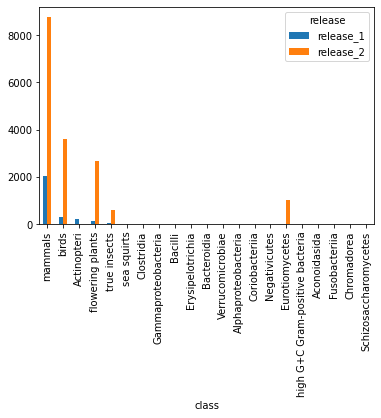

In [216]:
## Number of request for downloading data from both releases per class
groupped_df = df.groupby(['class', 'release']).uhost.count().unstack()
# Remove the rows where both release have no data
groupped_df = groupped_df[groupped_df['release_1'].notnull() | groupped_df['release_2'].notnull()]
groupped_df = groupped_df.sort_values('release_1', ascending=False)

groupped_df.plot(kind='bar', y=['release_1', 'release_2'])



## Number of unique IP that downloaded data from both releases per class

<AxesSubplot:xlabel='class'>

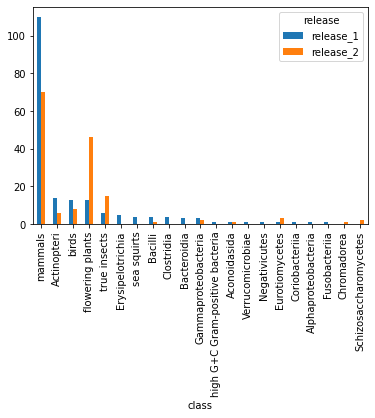

In [217]:
## Number of unique IP that downloaded data from both releases per class
groupped_df = df.groupby(['class', 'release']).uhost.nunique().unstack()
# Remove the rows where both release have no data
groupped_df = groupped_df[groupped_df['release_1'].notnull() | groupped_df['release_2'].notnull()]
groupped_df = groupped_df.sort_values('release_1', ascending=False)

# groupped_df
groupped_df.plot(kind='bar', y=['release_1', 'release_2'])

In [218]:
from matplotlib import pyplot as plt

def donut_plot(data_frame, group='commonname', value='file_size', nb_categories=6):
    if value == 'file_sise':
        groupped_df = data_frame.groupby([group])[value].sum().reset_index()
    elif value == 'uhost':
        groupped_df = data_frame.groupby([group])[value].nunique().reset_index()
    groupped_df=groupped_df.sort_values(value, ascending=False)
    groupped_df[:nb_categories]
    groupped_df_simple = pd.concat([
        groupped_df[:nb_categories],
        pd.DataFrame(
            [['Other species', sum(groupped_df[nb_categories:][value])]],
            columns=[group, value]
        )
    ])
    colors = ['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600']
    axes = groupped_df_simple.plot(y=value, labels=groupped_df_simple[group], kind='pie', autopct='%1.1f%%', figsize=(10, 10), legend=False, colors=colors, fontsize=16, counterclock=False, startangle=90)
    fig = axes.get_figure()
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    axes.set_ylabel('')


## Proportion of the all unique IPs downloading data from release 1 per species

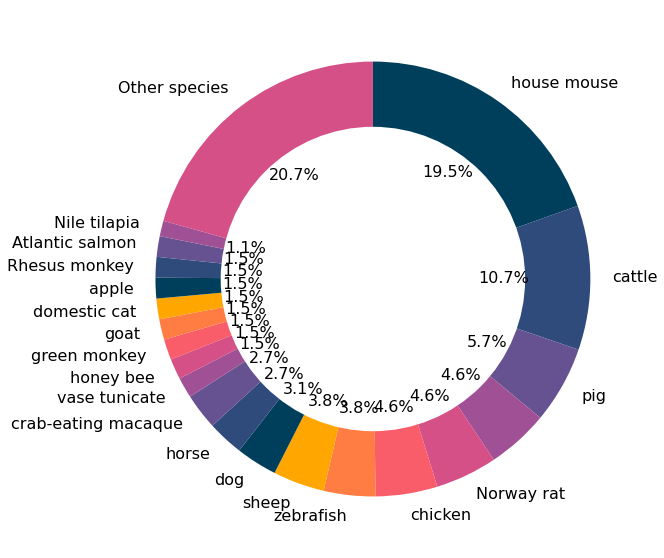

In [219]:
donut_plot(df[df['release'] == 'release_1'], 'commonname', value='uhost', nb_categories=20)

## Proportion of the all unique IPs downloading data from release 2 per species

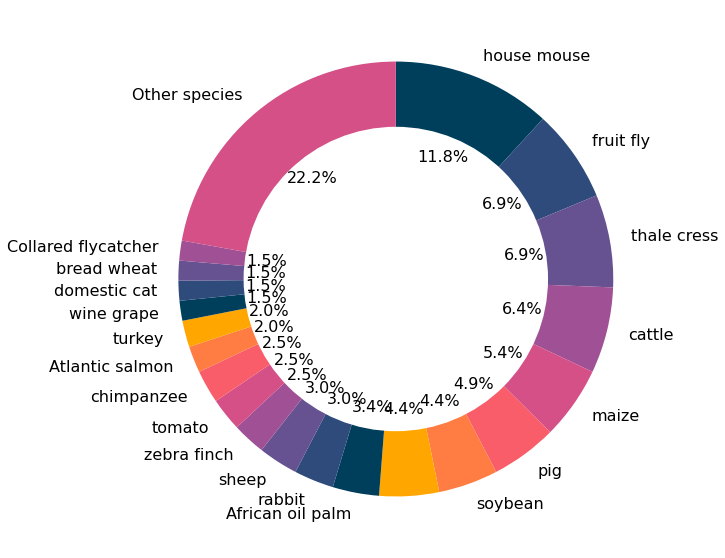

In [220]:
donut_plot(df[df['release'] == 'release_2'], 'commonname', value='uhost', nb_categories=20)

## Proportion of the all unique IPs downloading data from release 1 per class

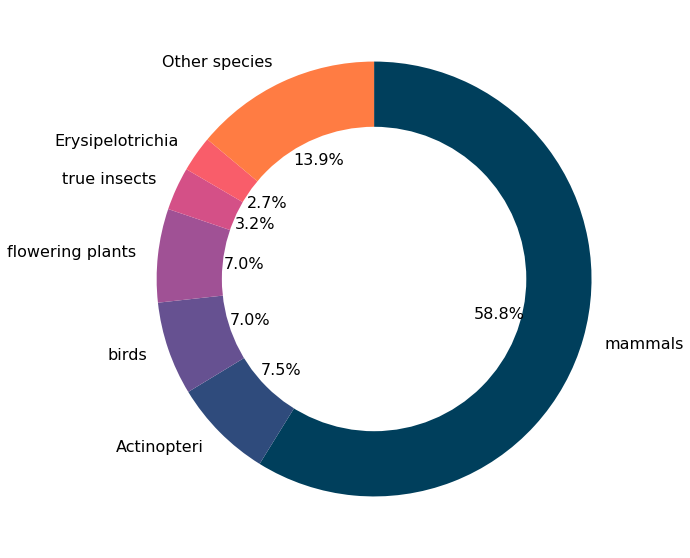

In [221]:
donut_plot(df[df['release'] == 'release_1'], 'class', value='uhost', nb_categories=6)

## Proportion of the all unique IPs downloading data from release 2 per class

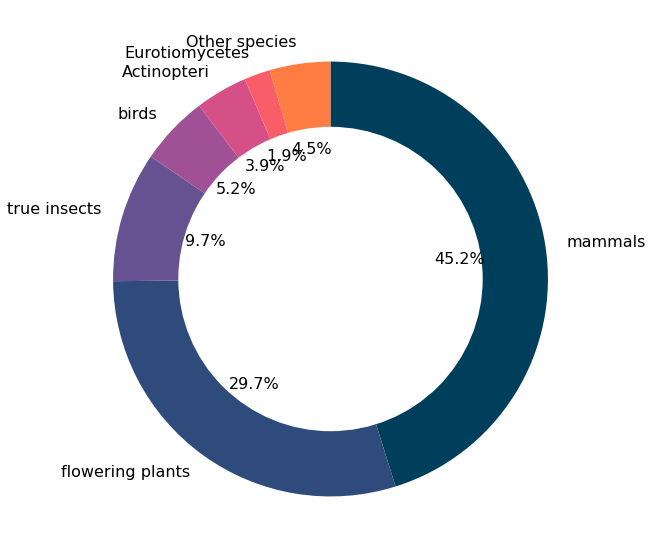

In [222]:
donut_plot(df[df['release'] == 'release_2'], 'class', value='uhost', nb_categories=6)